In [1]:
import os
os.chdir('/home/xinglong/git_local/sts-jax')
import jax
jax.config.update('jax_platform_name', 'cpu')

# Structural time series (STS) model with Poisson likelihood

In [2]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import lax, vmap
import time 
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd
tf.enable_v2_behavior()

import sts_jax.structural_time_series.sts_model as sts

2022-12-11 23:20:15.165057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-11 23:20:15.165086: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-11 23:20:15.165089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


### Generate Synthetic Data

In [3]:
def generate_data(num_training_steps, num_forecast_steps, key=jr.PRNGKey(5)):
    """Generate a time series with Poisson observation where the latent model
    has only one local_linear_trend_component.
    """
    num_steps = num_training_steps + num_forecast_steps

    # Generate parameters of the local_linear_trend component
    keys = jr.split(key, 5)
    level_scale = 1.5
    slope_scale = 0.01
    initial_level = jr.normal(keys[0])
    initial_slope = jr.normal(keys[1])
    obs_noise_scale = 10

    # Generate observed time series using the SSM representation.
    F = jnp.array([[1, 1],
                   [0, 1]])
    H = jnp.array([[1, 0]])
    Q = jnp.block([[level_scale, 0],
               [0, slope_scale]])
    R = obs_noise_scale

    def _step(current_state, key):
        key1, key2 = jr.split(key)
        log_obs_mean = H @ current_state
        next_state = F @ current_state + Q @ jr.normal(key2, shape=(2,))
        return next_state, log_obs_mean

    initial_state = jnp.array([initial_level, initial_slope])
    key_seq = jr.split(keys[2], num_steps)
    _, log_time_series_mean = lax.scan(_step, initial_state, key_seq)
    rates = jnp.exp(6+0.001*log_time_series_mean)
    counts = jr.poisson(keys[2], rates)

    counts_training = counts[:num_training_steps]
    rates_forecast = rates[num_training_steps:]
    
    return counts_training, rates_forecast

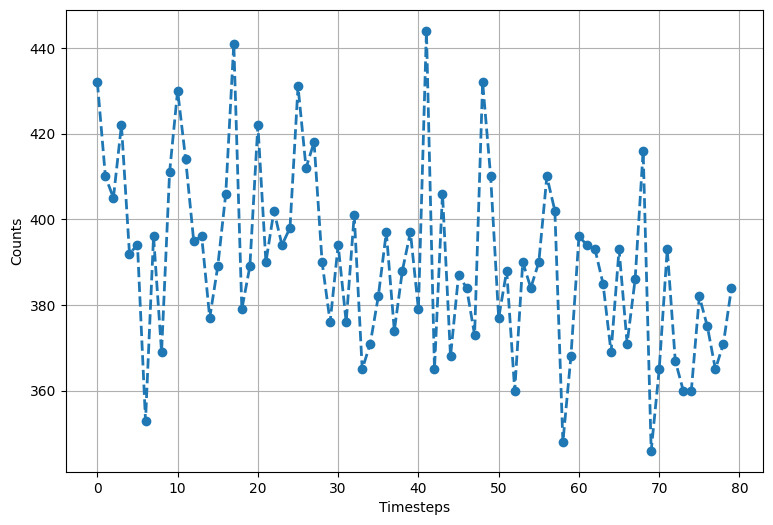

In [4]:
counts_training, rates_forecast = generate_data(80, 30)
# Plot the sequence of counts
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(counts_training, lw=2, linestyle='--', marker='o')
ax.set_ylabel("Counts")
ax.set_xlabel("Timesteps")
ax.grid()

### Plot function

In [10]:
def plot_forecast(model, param_samples, obs_time_series, num_training_steps, num_forecast_steps):
    # Forecast
    forecasts = model.forecast(param_samples, obs_time_series, num_forecast_steps)[1]
    forecasts = jnp.concatenate(forecasts, axis=0).squeeze()
    forecast_medians = jnp.median(forecasts, axis=0)
    forecast_quantiles = jnp.quantile(forecasts, jnp.array([0.1, 0.9]), axis=0)

    # Plot the forecast
    steps = jnp.arange(num_training_steps)
    forecast_steps = num_training_steps + jnp.arange(num_forecast_steps)
    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(steps, obs_time_series, lw=2, linestyle='--', marker='o', label='Observation', color='C0')
    ax.plot(forecast_steps, forecast_medians, lw='2', linestyle='--', marker='o',
            color='C1', label='Forecast')
    ax.fill_between(forecast_steps, forecast_quantiles[0], forecast_quantiles[1],
                    color='C1', alpha=0.3)
    ax.set_ylabel("Counts")
    ax.set_xlabel("Steps")
    ax.legend()
    ax.grid()
    fig.suptitle("Forecast of time series with Poisson observation", fontsize=15)

### Build the STS model

In [6]:
trend = sts.LocalLinearTrend()
model = sts.StructuralTimeSeries([trend],
                                 obs_distribution='Poisson',
                                 obs_time_series=counts_training)

### Model fitting

Running window adaptation


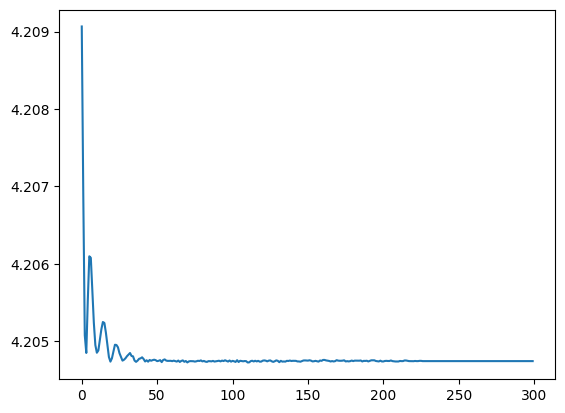

In [11]:
# Fit the model using HMC
opt_param, _losses = model.fit_mle(counts_training, num_steps=300)
param_samples, _log_probs = model.fit_hmc(
    num_samples=200, obs_time_series=counts_training, initial_params=opt_param)

plt.plot(_losses)

### Forecast

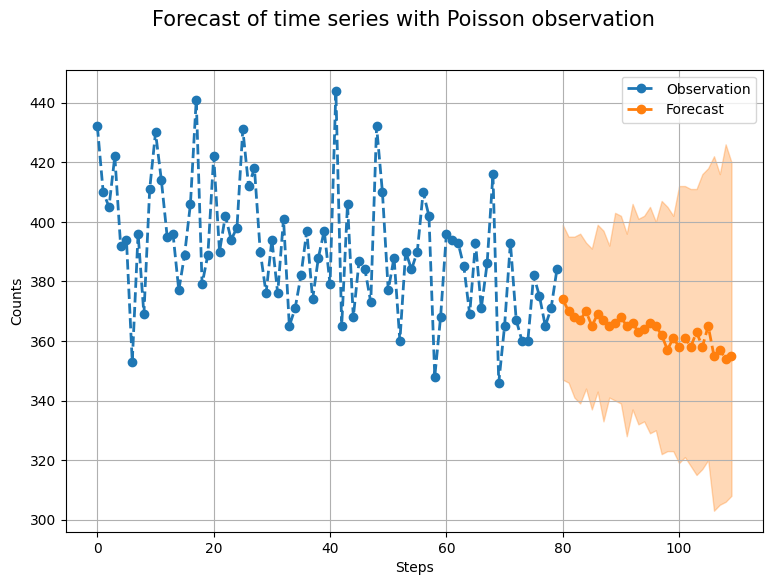

In [12]:
plot_forecast(model, param_samples, counts_training, 80, 30)

## Compare the speed of inference with tensorflow_probability

### Inference with tensorflow_probability.

In [13]:
def sts_poisson_model_tfp(observed_counts, positive_bijector=tfb.Softplus()):
    # The sts_model will operate on the series of transformed Poisson rate parameters,
    # instead of the observed time series.
    observed_counts = observed_counts.squeeze().astype(float)
    num_timesteps = observed_counts.shape[0]
    approximate_unconstrained_rates = positive_bijector.inverse(
        tf.convert_to_tensor(observed_counts) + 0.01)
    trend = tfp.sts.LocalLinearTrend(
        observed_time_series=approximate_unconstrained_rates)
    sts_model = tfp.sts.Sum([trend], observed_time_series=approximate_unconstrained_rates)

    # To use approximate inference for a non-Gaussian observation model, firstly encode
    # the STS model as a TFP JointDistribution. The random variables in this joint distribution
    # are the parameters of the STS model, the time series of latent Poisson rates, and the
    # observed counts.
    def sts_with_poisson_likelihood_model():
        # Encode the parameters of the STS model as random variables.
        param_vals = []
        for param in sts_model.parameters:
            param_val = yield param.prior
            param_vals.append(param_val)
        # Use the STS model to encode the log- (or inverse-softplus)
        # rate of a Poisson.
        unconstrained_rate = yield sts_model.make_state_space_model(
            num_timesteps, param_vals)
        rate = positive_bijector.forward(unconstrained_rate[..., 0])
        observed_counts = yield tfd.Poisson(rate, name='observed_counts')

    model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)
    # To infer the unobserved quantities in the model, given the observed counts.
    # First, we condition the joint log density on the observed counts.
    pinned_model = model.experimental_pin(observed_counts=observed_counts)
    return sts_model, pinned_model

def mcmc_sampler(model, num_results=500, num_burnin_steps=100):
    # We also need a constraining bijector to ensure that inference respects the constraints
    # on the STS model's parameters.
    constraining_bijector = model.experimental_default_event_space_bijector()
    
    # Use HMC (NUTS) to sample from the joint posterior over model parameters and latent rates.
    sampler = tfp.mcmc.TransformedTransitionKernel(
        tfp.mcmc.NoUTurnSampler(target_log_prob_fn=model.unnormalized_log_prob,
                                step_size=0.1),
        bijector=constraining_bijector)
    adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=sampler,
        num_adaptation_steps=int(0.8 * num_burnin_steps),
        target_accept_prob=0.75)
    initial_state = constraining_bijector.forward(
        type(model.event_shape)(*(tf.random.normal(part_shape) for part_shape in
            constraining_bijector.inverse_event_shape(model.event_shape))))
    
    # Speed up sampling by tracing with `tf.function`.
    @tf.function(autograph=False, jit_compile=True)
    def do_sampling():
        return tfp.mcmc.sample_chain(kernel=adaptive_sampler,
                                     current_state=initial_state,
                                     num_results=num_results,
                                     num_burnin_steps=num_burnin_steps,
                                     trace_fn=None)
    samples = do_sampling()
    return samples

### Inference comparison

In [51]:
def inference_comparison(num_training_steps, num_forecast_steps, key=jr.PRNGKey(5)):
    # Generate the synthetic dataset.
    counts_training, rates_forecast = generate_data(num_training_steps, num_forecast_steps, key)
    rates_forecast = rates_forecast.squeeze()

    # Learn the parameter with dynamax
    trend = sts.LocalLinearTrend()
    model_dynamax = sts.StructuralTimeSeries([trend], obs_distribution='Poisson',
                                     obs_time_series=counts_training)
    t0_dynamax = time.time()
    param_samples_dynamax, _log_probs = model_dynamax.fit_hmc(
        num_samples=200, obs_time_series=counts_training, warmup_steps=100, verbose=False)
    t1_dynamax = time.time()
    t_dynamax = t1_dynamax - t0_dynamax
    
    # Forecast with dynamax
    forecasts_dynamax = model_dynamax.forecast(
        param_samples_dynamax, counts_training, num_forecast_steps, num_forecast_samples=1)[0]
    forecasts_dynamax = jnp.concatenate(forecasts_dynamax, axis=0).squeeze()
    forecast_err_dynamax = jnp.mean((forecasts_dynamax-rates_forecast)**2)
    
    # Learn the parameter with tfp
    positive_bijector = tfb.Softplus()
    sts_tfp, model_tfp = sts_poisson_model_tfp(counts_training, positive_bijector)
    t0_tfp = time.time()
    samples_tfp = mcmc_sampler(model_tfp, num_results=200, num_burnin_steps=100)
    t1_tfp = time.time()
    t_tfp = t1_tfp - t0_tfp

    # Forecast with tfp
    param_samples_tfp = samples_tfp[:-1]
    unconstrained_rate_samples_tfp = samples_tfp[-1][..., 0]
    rate_samples_tfp = positive_bijector.forward(unconstrained_rate_samples_tfp)
    unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_tfp,
        observed_time_series=unconstrained_rate_samples_tfp,
        parameter_samples=param_samples_tfp,
        num_steps_forecast=num_forecast_steps)
    # Transform the forecast to positive-valued Poisson rates.
    rates_forecast_dist = tfd.TransformedDistribution(
          unconstrained_rates_forecast_dist, positive_bijector)
    forecasts_tfp = rates_forecast_dist.sample(200)
    forecasts_tfp = jnp.array(forecasts_tfp).squeeze()
    forecast_err_tfp = jnp.mean((forecasts_tfp-rates_forecast)**2)
    
    return counts_training, rates_forecast, forecasts_dynamax.mean(0), forecasts_tfp.mean(0), (t_dynamax, forecast_err_dynamax), (t_tfp, forecast_err_tfp)

In [52]:
num_training_steps = jnp.array([1e1, 5e1, 1e2, 5e2, 1e3, 1.5e3, 2e3]).astype(int)
num_forecast_steps = (0.3 * num_training_steps).astype(int)

In [65]:
a, b, c, d, e, f = inference_comparison(100, 10)

2022-12-12 00:02:22.833882: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at functional_ops.cc:373 : INTERNAL: No function library


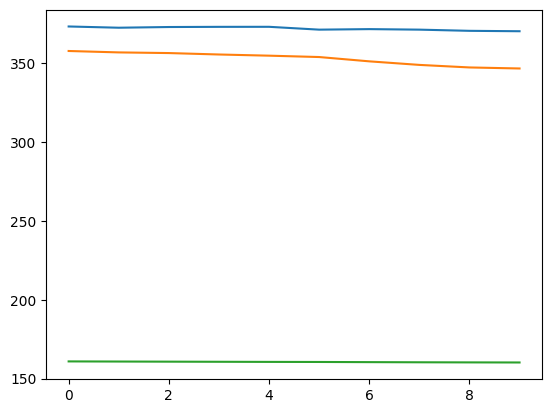

In [66]:
plt.plot(b)
plt.plot(c)
plt.plot(d)

In [48]:
print(c)
print(d)

(7.9239866733551025, DeviceArray(17652.098, dtype=float32))
(29.51433801651001, DeviceArray(3300.8867, dtype=float32))


In [ ]:
(t_dynamax, forecast_err_dynamax), (t_tfp, forecast_err_tfp) = vmap(inference_comparison)(
    num_training_steps, num_forecast_steps)